In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pyswarms as ps
from sklearn.metrics import classification_report
import seaborn as sns

# Divisão da base de dados e pré-processamento

In [2]:
base = pd.read_csv("abalone.csv")
base.info()

attributes = base.iloc[:, 1:9].values
sex = base.iloc[:, 0].values

scaler = MinMaxScaler(feature_range=(-1, 1))
attributes = scaler.fit_transform(attributes)

labelencoder = LabelEncoder()
sex = labelencoder.fit_transform(sex)

X_train, X_test, y_train, y_test =  train_test_split(attributes, sex, shuffle=True, random_state=1, test_size=.174)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


# Construção da topologia da RNA

In [3]:
n_inputs = 8
n_hidden = 20
n_classes = 3

num_samples = 3450

# Definição de função das camadas da RNA
def logits_function(p):
    W1 = p[0:160].reshape((n_inputs,n_hidden))
    b1 = p[160:180].reshape((n_hidden,))
    W2 = p[180:240].reshape((n_hidden,n_classes))
    b2 = p[240:243].reshape((n_classes,))

    z1 = X_train.dot(W1) + b1  
    a1 = np.tanh(z1)    
    logits = a1.dot(W2) + b2 
    return logits

# Definição da função da etapa foward do algoritmo BP
def forward_prop(params):
    logits = logits_function(params)

    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    corect_logprobs = -np.log(probs[range(num_samples), y_train])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

# Definição da função para auxiliar na execução do PSO
def f(x):
    
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

# Inicialização PSO

In [4]:
options = {'c1': 0.15, 'c2': 0.5, 'w':0.9}

dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

cost, pos = optimizer.optimize(f, iters=1000)


2021-11-08 09:30:00,081 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.15, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.84
2021-11-08 09:35:28,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8398324052045087, best pos: [ 9.42463055e-01 -2.38104250e+00  1.91781544e+00  1.92383582e+00
  7.39864658e-01  1.38887456e+00  1.12151398e+00  1.17919803e+00
  6.35153198e-01  1.60281901e+00  2.03787093e+00  1.54690117e+00
  1.28679863e+00  1.29436230e+00  1.15963694e+00  1.72921182e+00
  1.01623345e+00  2.07255919e-01 -2.42618510e-03  1.78599474e+00
  1.72961608e+00  8.92532441e-01  2.00212395e+00  3.16891108e-01
  1.69854952e+00  1.39735005e+00  1.69184912e+00  1.74519689e+00
  1.11768771e+00  1.04876028e+00  2.18829830e+00  1.10647947e+00
 -3.70650677e-01  1.49725563e+00  4.37287973e+00  2.63581336e+00
  1.08355649e-01  1.27032598e+00 -2.83991823e-01  6.71835177e-01
  1.43667363e+00  9.38561

# Previsão

In [6]:
def predict(pos):
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

forecasts = predict(pos)
print(f"Acurácia: {(predict(pos) == y_train).mean()}")

Acurácia: 0.5695652173913044


<AxesSubplot:>

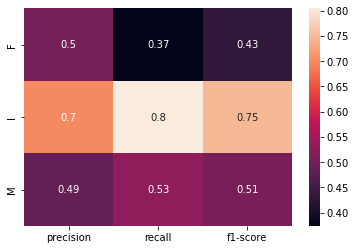

In [13]:
clf_report = classification_report(y_train, forecasts, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:-3].T, annot=True,yticklabels=["F","I","M"])